# STA4724 Final Project

**Members :** Cameron Ezazi,Vinh Van, Benjamin Willett, Tori Wright

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('./Speed Dating Data.csv', encoding = 'ISO-8859-1')

## Pre-Processing

In [2]:
#Remove variables that were recorded AFTER the matches were sent. Because these variables were surveyed after 
#our response variable, they are fundamentally useless
data = data.drop(data.columns[156:195], axis = 1)

#Removed entries of parameter 'wave'. Waves 6-9 were removed due to having differing rating parameters than the rest of the data

data = data[data['wave'] != 12]
data = data[(data['wave'] < 5) | (data['wave'] > 9)]



I removed rows that fell under wave 5-9 because the people in that wave had to grade in a different scale than the rest of the dataset and therefore it would affect our modelling if kept in.

I removed the participants in row 12 could only 'match' with up to 50% of the people they speed dated, there was an implicit bias before they were even surveyed and their wave was unique to every other wave

Removal of Trivial Variables based on Documentation about the surveying process

In [3]:
#Remove trivial/not useful variables based on information from the doc
data = data.drop(['iid','id','idg','condtn','round','position','positin1','order','partner','pid','undergra',
                'mn_sat','tuition','from','zipcode','income','field_cd','career_c','attr4_1','sinc4_1','intel4_1',
                'fun4_1','amb4_1','shar4_1','attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1','attr3_1',
                 'sinc3_1','fun3_1','intel3_1','amb3_1','attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1','dec',
                'prob','met','match_es','attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s',
                'sinc3_s','intel3_s','fun3_s','amb3_s','attr7_2','sinc7_2','intel7_2','fun7_2','amb7_2','shar7_2',
                'attr4_2','sinc4_2','intel4_2','fun4_2','amb4_2','shar4_2','attr2_2','sinc2_2','intel2_2','fun2_2',
                 'amb2_2','shar2_2','attr5_2','sinc5_2','intel5_2','fun5_2','amb5_2','expnum','prob_o','like','like_o'], axis=1)

### Dealing with Missing Values

You can use this code to check if there are any na or missing values in your dataset

In [4]:
#pd.options.display.max_rows = 4000
#data.isnull().sum().sum() -> Total number of missing values
#data.isnull().sum() #-> Missing values by column

For categorical variables I decided to just omit rows with missing values

In [5]:
data = data.dropna(subset=['race_o','race','field','career'])

For numerical variables I decided to perform an imputation, replacing missing cells with the mean of the column as I felt that would be better than outright dropping the rows

In [6]:
c = data.select_dtypes(np.number).columns
data[c] = data[c].fillna(data[c].mean())

## Train Test Split 

In [7]:
import sklearn.model_selection as ms


Y = data['match']
X = data.drop(['match','wave','field','career','dec_o'], axis = 1)

XTrain, XTest, YTrain, YTest = ms.train_test_split(X, Y, test_size= 0.3, random_state=1)

Since the data is imbalanced, we will resample the minority class (match=1) from the training set. 

In [8]:
print("Before OverSampling, counts of label '1': {}".format(sum(YTrain == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(YTrain == 0)))
  

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(XTrain, YTrain.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 696
Before OverSampling, counts of label '0': 3575 

After OverSampling, the shape of train_X: (7150, 69)
After OverSampling, the shape of train_y: (7150,) 

After OverSampling, counts of label '1': 3575
After OverSampling, counts of label '0': 3575


# KNN

In [9]:
#Using GridSearch to find the Best n neigbors
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


k_neighbours = list(range(1,33,2))   
n_grid = [{'n_neighbors': k_neighbours}]

model = neighbors.KNeighborsClassifier()
cv_knn = GridSearchCV(estimator=model, param_grid=n_grid, cv=ms.KFold(n_splits=10))
cv_knn.fit(X_train_res,y_train_res)

#prints the best n neighbors
best_k = cv_knn.best_params_['n_neighbors']
print(best_k)

1


In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#trains the model with best k
knnclf = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knnclf.fit(X_train_res,y_train_res)

KNN_pred = knnclf.predict(XTest)


In [11]:
#Classification Report
print(classification_report(YTest, KNN_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1526
           1       0.28      0.39      0.33       305

    accuracy                           0.73      1831
   macro avg       0.58      0.60      0.58      1831
weighted avg       0.77      0.73      0.75      1831



Text(0.5, 427.9555555555555, 'Predicted label')

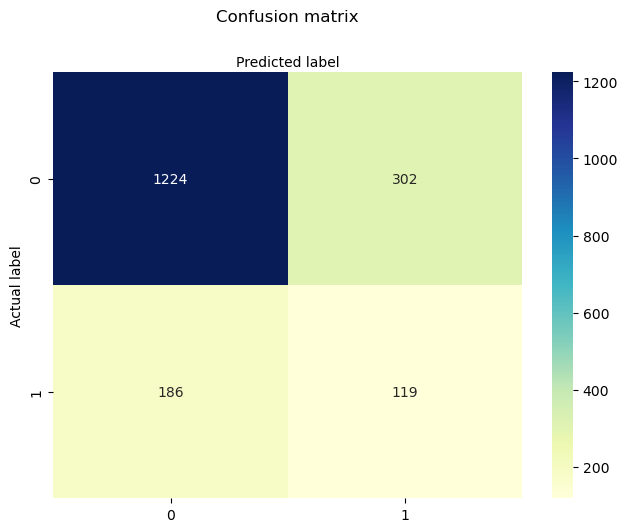

In [12]:
#Confusion Matrix for KNN

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(YTest, KNN_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Decision Trees

We use the upsampled dataset for testing of every model afterwards as well

In [13]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

#Creating parameters for the grid search and instantiating the tree model
depth_val = np.arange(2, 11)
leaf_val = np.arange(1, 33, step = 2)

grid_space = [{'max_depth': depth_val, 'min_samples_leaf': leaf_val}]
tree_model = tree.DecisionTreeClassifier()

cv_tree = GridSearchCV(estimator = tree_model, param_grid = grid_space, cv = ms.KFold(n_splits = 3))

#Fitting the model and finding best parameters for it
cv_tree.fit(X_train_res,y_train_res)

display(cv_tree.best_params_)

best_depth = cv_tree.best_params_['max_depth']
best_min_samples = cv_tree.best_params_['min_samples_leaf']

#Creating a new model using the best parameters
best_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = best_depth, min_samples_leaf = best_min_samples)
matchTree = best_tree.fit(X_train_res,y_train_res)

{'max_depth': 10, 'min_samples_leaf': 1}

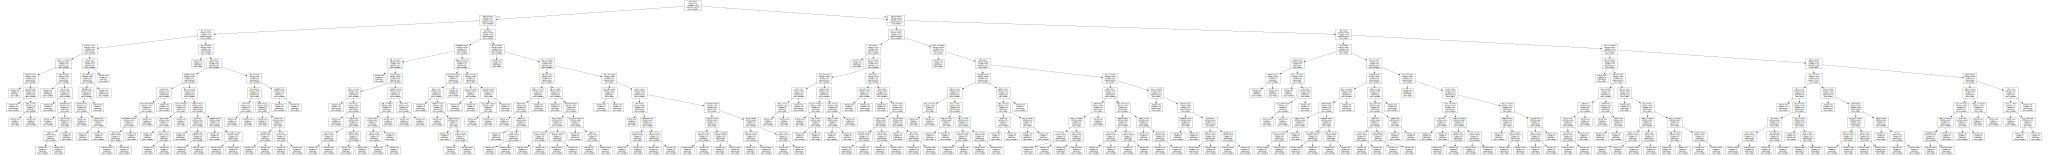

In [19]:
from graphviz import Source
#Visualize the Decision Tree
Source(tree.export_graphviz(matchTree, out_file=None, feature_names=X.columns, class_names = ['No Match','Match']))
#tree.export_graphviz(matchTree, out_file='DT.dot', feature_names=X.columns, class_names = ['No Match','Match'])

In [18]:
import pydot

(graph,) = pydot.graph_from_dot_file('DT.dot')
graph.write_png('DT.png')

In [16]:
match_prediction = matchTree.predict(XTest)
print(classification_report(YTest, match_prediction))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1526
           1       0.47      0.55      0.51       305

    accuracy                           0.82      1831
   macro avg       0.69      0.71      0.70      1831
weighted avg       0.83      0.82      0.83      1831



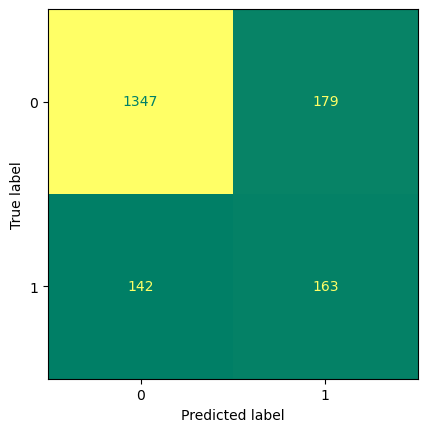

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix
confusion_matrix = ConfusionMatrixDisplay.from_estimator(matchTree, XTest, YTest, colorbar = False, cmap = 'summer')



In [18]:
#Importance of every feature in our model based on Decision Tree Testing

importances = matchTree.feature_importances_
columns = X.columns
i=0
while i < len(columns):
    print(f" The importance of feature ' {columns[i]}' is {round(importances[i] * 100,2)}%.")
    i += 1

 The importance of feature ' gender' is 0.0%.
 The importance of feature ' int_corr' is 0.47%.
 The importance of feature ' samerace' is 0.0%.
 The importance of feature ' age_o' is 0.63%.
 The importance of feature ' race_o' is 0.35%.
 The importance of feature ' pf_o_att' is 0.76%.
 The importance of feature ' pf_o_sin' is 0.41%.
 The importance of feature ' pf_o_int' is 0.28%.
 The importance of feature ' pf_o_fun' is 0.92%.
 The importance of feature ' pf_o_amb' is 0.58%.
 The importance of feature ' pf_o_sha' is 0.33%.
 The importance of feature ' attr_o' is 22.97%.
 The importance of feature ' sinc_o' is 1.52%.
 The importance of feature ' intel_o' is 1.92%.
 The importance of feature ' fun_o' is 6.43%.
 The importance of feature ' amb_o' is 0.33%.
 The importance of feature ' shar_o' is 8.72%.
 The importance of feature ' met_o' is 0.95%.
 The importance of feature ' age' is 0.61%.
 The importance of feature ' race' is 0.47%.
 The importance of feature ' imprace' is 0.0%.
 The i

# Random Forest

Instead of GridSearch, we manually tuned for best n_estimators and settled on 1000 as that offered the best accuracy per run time efficiency. We also used the same Training and Testing Set we used for Decision Trees.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state =1)
rf.fit (X_train_res,y_train_res)

RandomForestClassifier(n_estimators=1000, random_state=1)

In [20]:
predictions = rf.predict(XTest)
print(classification_report(YTest, predictions))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1526
           1       0.67      0.43      0.52       305

    accuracy                           0.87      1831
   macro avg       0.78      0.69      0.72      1831
weighted avg       0.86      0.87      0.86      1831



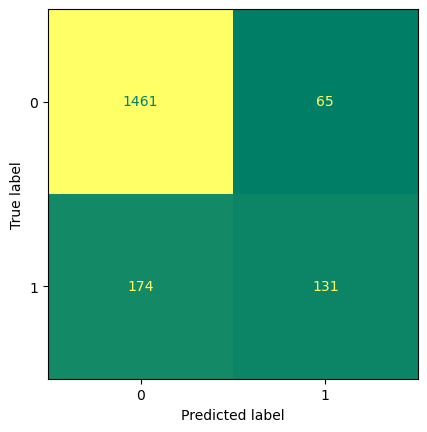

In [21]:
confusion_matrix = ConfusionMatrixDisplay.from_estimator(rf, XTest, YTest, colorbar = False, cmap = 'summer')

In [22]:
#Importance of Random Forest Features

importances = rf.feature_importances_
columns = X.columns
i=0
while i < len(columns):
    print(f" The importance of feature ' {columns[i]}' is {round(importances[i] * 100,2)}%.")
    i += 1

 The importance of feature ' gender' is 0.12%.
 The importance of feature ' int_corr' is 1.24%.
 The importance of feature ' samerace' is 0.38%.
 The importance of feature ' age_o' is 1.2%.
 The importance of feature ' race_o' is 1.15%.
 The importance of feature ' pf_o_att' is 1.26%.
 The importance of feature ' pf_o_sin' is 1.09%.
 The importance of feature ' pf_o_int' is 1.33%.
 The importance of feature ' pf_o_fun' is 1.3%.
 The importance of feature ' pf_o_amb' is 1.0%.
 The importance of feature ' pf_o_sha' is 1.16%.
 The importance of feature ' attr_o' is 6.96%.
 The importance of feature ' sinc_o' is 2.71%.
 The importance of feature ' intel_o' is 2.7%.
 The importance of feature ' fun_o' is 6.75%.
 The importance of feature ' amb_o' is 1.83%.
 The importance of feature ' shar_o' is 6.79%.
 The importance of feature ' met_o' is 0.61%.
 The importance of feature ' age' is 0.92%.
 The importance of feature ' race' is 0.62%.
 The importance of feature ' imprace' is 0.75%.
 The imp

**ROC and AUC Curve for all Models**

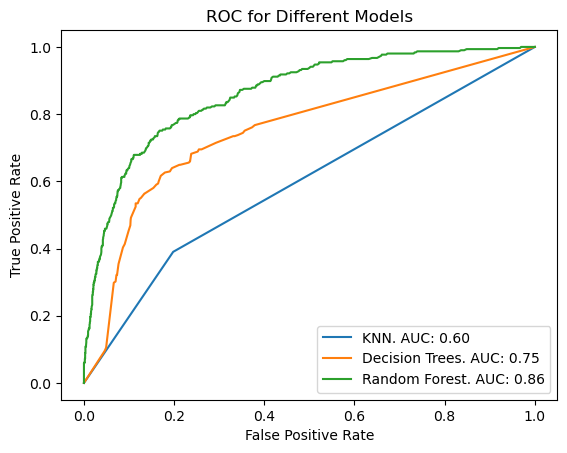

In [23]:
# make roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#KNN
fpr_knn, tpr_knn, _ = roc_curve(YTest, knnclf.predict_proba(XTest)[:,1])
auc_knn = auc(fpr_knn,tpr_knn)

#Decision Trees
fpr_DT,tpr_DT,_ = roc_curve(YTest, matchTree.predict_proba(XTest)[:,1])
auc_DT = auc(fpr_DT,tpr_DT)

#Random Forest
fpr_RF,tpr_RF,_ = roc_curve(YTest, rf.predict_proba(XTest)[:,1])
auc_RF = auc(fpr_RF,tpr_RF)

#plot the info
plt.plot(fpr_knn,tpr_knn, label='KNN. AUC: {0:0.2f}'.format(auc_knn))
plt.plot(fpr_DT,tpr_DT, label='Decision Trees. AUC: {0:0.2f}'.format(auc_DT))
plt.plot(fpr_RF,tpr_RF, label='Random Forest. AUC: {0:0.2f}'.format(auc_RF))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Different Models')
plt.legend(loc='lower right')